In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.4 MB/s eta 0:00:00


In [ ]:
#load all libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW, AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, BertForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

###Extrinsic

In [ ]:
import json

# Specify the path to the downloaded NewsQA JSON file
newsqa_file_path = "combined-newsqa-data-v1.json"

# Load the JSON file
with open(newsqa_file_path, "r", encoding="utf-8") as file:
    newsqa_data = json.load(file)

# Now `newsqa_data` contains the entire NewsQA dataset
# You can access different parts of the dataset based on its structure


In [ ]:
!git clone https://github.com/amazon-science/qa-dataset-converter

In [ ]:
!git clone https://github.com/mandarjoshi90/triviaqa

In [ ]:
%cd qa-dataset-converter/newsqa

In [ ]:
!ls

In [ ]:
!python /content/qa-dataset-converter/newsqa/newsqa_to_squad.py --newsqa_file newsqa-data-v1.csv --output_file newsqa_dev.json

###Loading the dataset

In [ ]:
from datasets import load_dataset

In [ ]:
squad_dataset = load_dataset("squad_v2")
# Access the training split
train_data = squad_dataset["train"]
# Access the validation split
validation_data = squad_dataset["validation"]

In [ ]:
train_data[140]

In [ ]:
type(train_data)

In [ ]:
len(train_data)

In [ ]:
def get_data(data):
  title_list = []
  context_list = []
  question_list = []
  answer_list = []
  num_questions = 0
  num_questions_pos = 0
  num_questions_impos = 0

  for e in data:
    num_questions += 1
    if(e['answers']['text']==[]):
      #impossible
      num_questions_impos += 1
    else:
      title_list.append(e['title'])
      context_list.append(e['context'])
      question_list.append(e['question'])
      e['answers']['text'] = e['answers']['text'][0]
      e['answers']['answer_start'] = e['answers']['answer_start'][0]
      answer_list.append(e['answers'])
      num_questions_pos += 1

  return title_list, context_list, question_list, answer_list, num_questions, num_questions_pos, num_questions_impos



In [ ]:
title_list_train, context_list_train, question_list_train, answer_list_train, num_questions_train, num_questions_pos_train, num_questions_impos_train = get_data(train_data)

In [ ]:
title_list_test, context_list_test, question_list_test, answer_list_test, num_questions_test, num_questions_pos_test, num_questions_impos_test= get_data(validation_data)

In [ ]:
print(f"Total number of questions: {num_questions_train+num_questions_test}")
print(num_questions_test)
print(f"Total number of Answerable questions: {num_questions_pos_train+num_questions_pos_test}")
print(f"Total number of impossible questions: {num_questions_impos_train+num_questions_impos_test}")

In [ ]:
def add_answer_ends(answers):
  for e in answers:
    e['text'] = e['text'].lower()
    e['answer_end']=[]
    e['answer_end'] .append(e['answer_start'] + len(e['text']))
    e['answer_end'] = e['answer_end'][0]

  return answers

In [ ]:
answer_list_train = add_answer_ends(answer_list_train)
answer_list_test = add_answer_ends(answer_list_test)

In [ ]:
test_rec = 30
print(f"Context: {context_list_test[test_rec]}")
print(f"Question: {question_list_test[test_rec]}")
print(f"Answer: {answer_list_test[test_rec]}")

In [ ]:
#add for validation set

###Tokenization

In [ ]:
# Initialize an empty list to store token lengths
token_lengths = []

# Loop through each context passage in the text_data list
for passage in context_list_train:
    # Remove leading and trailing white spaces from the passage
    passage = passage.strip()

    # Split the cleaned passage into tokens using spaces and count the number of tokens
    token_count = len(passage.split())

    # Append the token count to the token_lengths list
    token_lengths.append(token_count)

# Find and print the maximum token length observed in the context passages
max_token_length = max(token_lengths)
print(f"Maximum token length in context passages: {max_token_length}")

# Create a histogram to visualize the distribution of token lengths
plt.hist(token_lengths, bins=20)
plt.ylabel('Count')
plt.xlabel('Token Length')
plt.title('Distribution of Context Passage Token Lengths')

In [ ]:
# Initialize an empty list to store the token lengths of context passages
token_lengths_2 = []

# Loop through each context passage in the train_contexts list
for question in question_list_train:
    # Remove leading and trailing white spaces from the passage
    cleaned_question = question.strip()

    # Split the cleaned context passage into tokens based on spaces and count the number of tokens
    token_count = len(cleaned_question.split(' '))

    # Append the token count to the token_lengths list
    token_lengths_2.append(token_count)

# Find and print the maximum token length observed in the context passages
max_token_length = max(token_lengths_2)
print(f"Maximum token length in questions: {max_token_length}")

# Create a histogram to visualize the distribution of token lengths
plt.hist(token_lengths_2, bins=20)  # You can adjust the number of bins for your visualization
plt.ylabel('Count')
plt.xlabel('Token Length')
plt.title('Distribution of Question Token Lengths')


In [ ]:
Max_Length = 250

In [ ]:
MODEL_PATH = "bert-base-uncased"

In [ ]:
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)

train_encodings_fast = tokenizerFast(question_list_train, context_list_train,  max_length = Max_Length, truncation=True, padding=True)
test_encodings_fast = tokenizerFast(question_list_test, context_list_test,  max_length = Max_Length, truncation=True, padding=True)


In [ ]:

print(train_encodings_fast.keys())
print(test_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(train_encodings_fast['input_ids'][10][0:25])
print(train_encodings_fast['token_type_ids'][10][0:25])
print(train_encodings_fast['attention_mask'][10][0:25])

print(len(train_encodings_fast['input_ids'][0]))
#attention mask is 0 for padding tokens and 1 for non-padding tokens
#input ids is the token integer for each word in the input sequence
#token type ids is 0 for questions and 1 for contexts - used in a multi-input model

#DOUBT ?? how do we combine the 2 inputs into a single 250 length object?

In [ ]:
# # Select the first sequence (index 0) from input_ids
# input_ids_sequence = train_encodings_fast['input_ids'][10]
# decoded_sequence = tokenizerFast.decode(input_ids_sequence, skip_special_tokens=True)
# print(len(decoded_sequence.split(' ')))
# print(type(decoded_sequence))
# print(decoded_sequence)
# print(len(context_list_train[0].split(' ')))
# print(context_list_train[0])

In [ ]:
answer_list_test[101]

In [ ]:
answer_encoding_fast = tokenizerFast(answer_list_train[0]['text'],  max_length = Max_Length, truncation=True, padding=True)
answer_encoding_fast

In [ ]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(answer_list_train[idx]['text'],  max_length = Max_Length, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):

            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)


In [ ]:
def ret_Answer_start_and_end_test(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(answer_list_test[idx]['text'],  max_length = Max_Length, truncation=True, padding=True)
    for a in range( len(test_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != test_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
def calc_answer_start_end_train(index):
  start=0
  end=0
  answer_encoding_fast = tokenizerFast(answer_list_train[index]['text'],  max_length = Max_Length, truncation=True, padding=True)
  l = len(answer_list_train[index]['text'][0].split(' '))



  for x in range(len(train_encodings_fast['input_ids'][index]) - l):
    match = True
    for i in range(l):
      if(answer_encoding_fast['input_ids'][0][i+1]!=train_encodings_fast['input_ids'][index][x+i]):
        match = False
        break
    if(match):
      start = x
      end = x+l
      break
  return start,end
    # if answer_encoding_fast['input_ids'][0]  ==  train_encodings_fast['input_ids'][index][x:x+len(answer_encoding_fast['input_ids'][0])]:
    #   start = x+1
    #   end = x+len(answer_encoding_fast['input_ids'][0])+1
    #   break
  # return start,end


In [ ]:
# print(len(train_encodings_fast['input_ids'][10]))
# answer_encoding_fast = tokenizerFast(answer_list_train[10]['text'],  max_length = 250, truncation=True, padding=True)
# # input_ids_sequence = train_encodings_fast['input_ids'][0]
# # decoded_sequence = tokenizerFast.decode(input_ids_sequence)
# # print(len(decoded_sequence.split(' ')))
# print(len(answer_list_train[10]['text'][0].split(' ')))
# print(len(answer_encoding_fast['input_ids'][0]))
# decoded_sequence = tokenizerFast.decode(answer_encoding_fast['input_ids'][0])
# print(decoded_sequence)
# print(answer_encoding_fast['input_ids'][0])

In [ ]:
# test_rec=0

# z,x = calc_answer_start_end_train(test_rec)
# print(z, x)

# predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
# print(tokenizerFast.decode(predict_answer_tokens))
# print(answer_list_train[test_rec]['text'])
# print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
  #print(h)
  s, e = ret_Answer_start_and_end_train(h)

  start_positions.append(s)
  end_positions.append(e)
  if s==0:
    ctr = ctr + 1

train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

In [ ]:
train_encodings_fast.keys()

In [ ]:
def calc_answer_start_end_test(index):
  start=0
  end=0
  answer_encoding_fast = tokenizerFast(answer_list_test[index]['text'],  max_length = Max_Length, truncation=True, padding=True)
  l = len(answer_list_test[index]['text'][0].split(' '))



  for x in range(len(test_encodings_fast['input_ids'][index]) - l):
    match = True
    for i in range(l):
      if(answer_encoding_fast['input_ids'][0][i+1]!=test_encodings_fast['input_ids'][index][x+i]):
        match = False
        break
    if(match):
      start = x
      end = x+l
      break
  return start,end
    # if answer_encoding_fast['input_ids'][0]  ==  train_encodings_fast['input_ids'][index][x:x+len(answer_encoding_fast['input_ids'][0])]:
    #   start = x+1
    #   end = x+len(answer_encoding_fast['input_ids'][0])+1
    #   break
  # return start,end


In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(test_encodings_fast['input_ids'])):
    #print(h)
    s, e = ret_Answer_start_and_end_test(h)

    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


test_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

OPTIONAL

In [ ]:
tokenizer2 = BertTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
model2 = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")

In [ ]:
question= question_list_train[2]
text = context_list_train[2]

print(question)
print(text)

In [ ]:
inputs = tokenizer2(question, text, return_tensors="pt", padding=True, truncation=True, max_length = Max_Length)
with torch.no_grad():
  outputs = model2(**inputs)

In [ ]:
print(len(train_encodings_fast['input_ids']))
print(inputs["attention_mask"].shape)
print(inputs["token_type_ids"].shape)


In [ ]:
answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()
print(answer_start_index)
print(answer_end_index)

In [ ]:
predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer2.decode(predict_answer_tokens)

Creating Datasets and Dataloaders

In [ ]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'inputIDs': torch.tensor(self.encodings['input_ids'][i]),
            'tokenIDs': torch.tensor(self.encodings['token_type_ids'][i]),
            'attMask': torch.tensor(self.encodings['attention_mask'][i]),
            'startPos': torch.tensor(self.encodings['start_positions'][i]),
            'endPos': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
train_dataset = InputDataset(train_encodings_fast)
test_dataset = InputDataset(test_encodings_fast)

In [ ]:
# print(len(train_dataset))
# print(train_dataset.keys())

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=32)
# TODO: change the batch_size later

Creating the model

In [ ]:
#model = BertForQuestionAnswering.from_pretrained(MODEL_PATH)
bert_model = BertModel.from_pretrained(MODEL_PATH)

In [ ]:
print(bert_model)

In [ ]:
#no_layers = 6
#for param in bert_model.encoder.layer[:no_layers].parameters():
#    param.requires_grad = False

In [ ]:
#defining the model

class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768*2, 384 )
        self.l2 = nn.Linear(384 , 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]

        #original implementation
        #out= hidden_states[-1]

        #our innovation
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1) # taking Start logits from last BERT layer, End Logits from third to last layer

        logits = self.linear_relu_stack(out)

        ans_start_index, ans_end_index = logits.split(1, dim=-1)

        ans_start_index = ans_start_index.squeeze(-1)
        ans_end_index = ans_end_index.squeeze(-1)

        return ans_start_index, ans_end_index

In [ ]:
import torch.nn as nn

class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model  # Assuming `bert_model` is defined elsewhere
        self.drop_out = nn.Dropout(0.1)
        self.lstm = nn.LSTM(768, 384, bidirectional=True, batch_first=True)
        self.relu = nn.ReLU()
        self.linear_stack = nn.Sequential(
            nn.Linear(768, 384),
            self.relu,
            nn.Linear(384 * 2, 2)  # Adjusted the input size based on LSTM bidirectional output
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]

        # Concatenate the hidden states from the last two layers
        out = torch.cat((hidden_states[-1], hidden_states[-2]), dim=-1)

        # Apply dropout
        out = self.drop_out(out)

        # Apply LSTM
        out, _ = self.lstm(out)

        # Flatten the output before passing through linear layers
        out = out.contiguous().view(out.size(0), -1)

        # Apply linear layers
        logits = self.linear_stack(out)

        ans_start_index, ans_end_index = logits.split(1, dim=-1)

        ans_start_index = ans_start_index.squeeze(-1)
        ans_end_index = ans_end_index.squeeze(-1)

        return ans_start_index, ans_end_index


In [ ]:
model = QAModel()

model = model.to('cuda')

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['inputIDs', 'tokenIDs', 'attMask', 'startPos', 'endPos'])

In [ ]:
print(data['inputIDs'].shape)


torch.Size([32, 250])


In [ ]:
#run one row
'''
model.to(device)
model.train()
input_ids = data['inputIDs'][0].unsqueeze(0).to(device)
attention_mask = data['attMask'][0].unsqueeze(0).to(device)
start_positions = data['startPos'][0].unsqueeze(0).to(device)
end_positions = data['endPos'][0].unsqueeze(0).to(device)
token_type_ids = data['tokenIDs'][0].unsqueeze(0).to(device)

out_start, out_end = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
'''

In [ ]:
#print(f"start logits shape: {out_start.shape}")
#print(f"end logits shape: {out_end.shape}")

In [ ]:
#answer_start_index = out_start.argmax()
#answer_end_index = out_end.argmax()
#print(answer_start_index)
#print(answer_end_index)



In [ ]:
'''predict_answer_tokens = data['inputIDs'][0, answer_start_index]
predict_answer_end_tokens = data['inputIDs'][0, answer_end_index]
# tokenizer2.decode(predict_answer_tokens)
tokenizerFast.decode(predict_answer_end_tokens)
'''

"predict_answer_tokens = data['inputIDs'][0, answer_start_index]\npredict_answer_end_tokens = data['inputIDs'][0, answer_end_index]\n# tokenizer2.decode(predict_answer_tokens)\ntokenizerFast.decode(predict_answer_end_tokens)\n"

Training loop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive/BITS_NLP'
#%cd '/content/drive/MyDrive/BITS_NLP'

In [ ]:
model.load_state_dict(torch.load('checkpoint.pth'))

In [ ]:
#import trained model
#model = QAModel()
#model.load_state_dict(torch.load('checkpoint.pth'))

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
''' = 2e-5
weight_decay = 2e-2
gamma = 0.9
optimizer1 = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn1 = nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer1, gamma=gamma)
total_accuracy = []
total_loss = []
'''

' = 2e-5\nweight_decay = 2e-2\ngamma = 0.9\noptimizer1 = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)\nloss_fn1 = nn.CrossEntropyLoss()\nscheduler = ExponentialLR(optimizer1, gamma=gamma)\ntotal_accuracy = []\ntotal_loss = []\n'

In [ ]:
def train(model, data, epochNumber, optimizer, loss_fn, name):
  model = model.train()
  loss_list = []
  accuracy_list = []
  count = 0
  batch_count = 0
  #batch_save=0
  for batch in tqdm(data, desc = 'Current epoch number '):
    optimizer.zero_grad()
    input_ids = batch['inputIDs'].to(device)
    attention_mask = batch['attMask'].to(device)
    token_type_ids = batch['tokenIDs'].to(device)
    start_positions = batch['startPos'].to(device)
    end_positions = batch['endPos'].to(device)
    out_start, out_end = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    #loss = loss_fn(out_start, out_end, start_positions, end_positions)  # <---BASELINE.  Cross Entropy Loss is returned by Default

    loss = loss_fn(out_start, start_positions) + loss_fn(out_end, end_positions)
    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()

    start_prediction = torch.argmax(out_start, dim=1)
    end_prediction = torch.argmax(out_end, dim=1)

    accuracy_list.append(((start_prediction == start_positions).sum()/len(start_prediction)).item())
    accuracy_list.append(((end_prediction == end_positions).sum()/len(end_prediction)).item())
    batch_count = batch_count + 1
    #batch_save=batch_save+1
    if batch_count==250:
        total_accuracy.append(sum(accuracy_list)/len(accuracy_list))
        loss_average = sum(loss_list)/len(loss_list)
        total_loss.append(loss_average)
        if epochNumber==1:
          print("current accuracy : " + str(total_accuracy[-1]))
          print("current loss : " + str(total_loss[-1]))
        batch_count = 0
        if total_accuracy[-1]==max(total_accuracy):
          torch.save(model.state_dict(), name)
          print("Saving the model for epoch number "+ str(epochNumber))

  scheduler.step()
  ret_acc = sum(accuracy_list)/len(accuracy_list)
  ret_loss = sum(loss_list)/len(loss_list)
  return(ret_acc, ret_loss)

In [ ]:
def eval_model(model, dataloader):
    model = model.eval()
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['inputIDs'].to(device)
            attention_mask = batch['attMask'].to(device)
            token_type_ids = batch['tokenIDs'].to(device)
            start_true = batch['startPos'].to(device)
            end_true = batch['endPos'].to(device)

            out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)

            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

        ret_acc = sum(acc)/len(acc)
        #ret_loss = 0
        #ret_loss = sum(losses)/len(losses)


    return acc, ret_acc

###Base Model

In [ ]:
EPOCHS = 5

model.to(device)

for epoch in range(EPOCHS):
    print("epoch number is " + str(epoch))
    train_acc, train_loss = train(model, train_data_loader, epoch+1, optimizer1, loss_fn1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")

    #if epoch==2:
      #val_acc, val_loss = eval_model(model, test_data_loader)
      #print(f"Testing Accuracy: {val_acc}   Testing Loss: {val_loss}")
    # val_acc = eval_model(model, valid_data_loader)
    # print(f"Validation Accuracy: {val_acc}")


epoch number is 0


Current epoch number :   9%|▉         | 250/2714 [06:01<59:57,  1.46s/it]

current accuracy : 0.3128125
current loss : 5.850066661834717


Current epoch number :  18%|█▊        | 500/2714 [12:07<53:49,  1.46s/it]

current accuracy : 0.426
current loss : 4.659376241922379


Current epoch number :  28%|██▊       | 750/2714 [18:13<48:11,  1.47s/it]

current accuracy : 0.4783541666666667
current loss : 4.122625838120778


Current epoch number :  37%|███▋      | 999/2714 [24:18<42:06,  1.47s/it]

current accuracy : 0.51046875
current loss : 3.8032863845825196


Current epoch number :  37%|███▋      | 1000/2714 [24:21<56:41,  1.98s/it]

Saving the model for epoch number 1


Current epoch number :  46%|████▌     | 1250/2714 [30:28<35:45,  1.47s/it]

current accuracy : 0.532875
current loss : 3.585979307842255


Current epoch number :  55%|█████▌    | 1500/2714 [36:35<29:38,  1.46s/it]

current accuracy : 0.54984375
current loss : 3.427627196709315


Current epoch number :  64%|██████▍   | 1750/2714 [42:41<23:27,  1.46s/it]

current accuracy : 0.5623571428571429
current loss : 3.304431213378906


Current epoch number :  74%|███████▎  | 1999/2714 [48:46<17:31,  1.47s/it]

current accuracy : 0.5737578125
current loss : 3.198438799440861


Current epoch number :  74%|███████▎  | 2000/2714 [48:53<36:22,  3.06s/it]

Saving the model for epoch number 1


Current epoch number :  83%|████████▎ | 2250/2714 [55:00<11:20,  1.47s/it]

current accuracy : 0.5815069444444444
current loss : 3.1166555647320218


Current epoch number :  92%|█████████▏| 2500/2714 [1:01:07<05:14,  1.47s/it]

current accuracy : 0.58963125
current loss : 3.0365468365192414


Current epoch number : 100%|██████████| 2714/2714 [1:06:20<00:00,  1.47s/it]


Train Accuracy: 0.595797254976404      Train Loss: 2.9818682467665143
epoch number is 1


Current epoch number :  37%|███▋      | 1000/2714 [24:28<1:03:13,  2.21s/it]

Saving the model for epoch number 2


Current epoch number :  74%|███████▎  | 2000/2714 [48:58<26:44,  2.25s/it]

Saving the model for epoch number 2


Current epoch number : 100%|██████████| 2714/2714 [1:06:21<00:00,  1.47s/it]


Train Accuracy: 0.7231749723677083      Train Loss: 1.8281613364980427
epoch number is 2


Current epoch number :  37%|███▋      | 1000/2714 [24:23<55:36,  1.95s/it]

Saving the model for epoch number 3


Current epoch number :  74%|███████▎  | 2000/2714 [48:45<23:07,  1.94s/it]

Saving the model for epoch number 3


Current epoch number : 100%|██████████| 2714/2714 [1:06:06<00:00,  1.46s/it]


Train Accuracy: 0.7843162767155344      Train Loss: 1.3491209464294558
epoch number is 3


Current epoch number :  22%|██▏       | 604/2714 [14:44<51:25,  1.46s/it]

In [ ]:
#model = QAModel()
#model.load_state_dict(torch.load('checkpoint.pth'))

In [ ]:
#Testing after training for three iterations

acc_list, test_acc = eval_model(model, test_data_loader)
print(f"Testing Accuracy: {test_acc} " )

Running Evaluation: 100%|██████████| 186/186 [01:32<00:00,  2.01it/s]

Testing Accuracy: 0.6772513440860215 


In [ ]:
# saving in drive
torch.save(model.state_dict(), '/kaggle/working/best_model_state.bin')

In [ ]:
# plot Accuracy
plt.plot(total_acc, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");

In [ ]:
# plot Loss
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

In [ ]:
# plot Accuracy
plt.plot(total_acc, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");


# plot Loss
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

###ZERO shot learning

In [ ]:
model = QAModel()

model = model.to('cuda')

In [ ]:
acc_list, test_acc = eval_model(model, test_data_loader)
print(f"Testing Accuracy: {test_acc} " )

Running Evaluation: 100%|██████████| 186/186 [01:25<00:00,  2.17it/s]

Testing Accuracy: 0.006132392473118279 


###Adding a LSTM layer-

In [ ]:
model = QAModel()

model = model.to('cuda')


if next(model.parameters()).is_cuda:
    print("Model is on CUDA (GPU).")
else:
    print("Model is on CPU.")

Model is on CUDA (GPU).


In [ ]:
learning_rate = 2e-5
weight_decay = 2e-2
gamma = 0.9
optimizer1 = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn1 = nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer1, gamma=gamma)
total_accuracy = []
total_loss = []

In [ ]:
#training
EPOCHS = 3

for epoch in range(EPOCHS):
    print("epoch number is " + str(epoch))
    train_acc, train_loss = train(model, train_data_loader, epoch+1, optimizer1, loss_fn1, 'model_lstm.pth')
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    acc_list, test_acc = eval_model(model, test_data_loader)
    print(f"Testing accuracy after epoch {epoch} is {test_acc}")

epoch number is 0


Current epoch number :   0%|          | 0/2714 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Current epoch number :   0%|          | 0/2714 [00:00<?, ?it/s]


RuntimeError: ignored

###Different Model Architectures - linear layer is 768*2 - 384 final layer is 384 * 2

In [ ]:
model = QAModel()

model = model.to('cuda')


if next(model.parameters()).is_cuda:
    print("Model is on CUDA (GPU).")
else:
    print("Model is on CPU.")

Model is on CUDA (GPU).


In [ ]:
learning_rate = 2e-5
weight_decay = 2e-2
gamma = 0.9
optimizer1 = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn1 = nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer1, gamma=gamma)
total_accuracy = []
total_loss = []

In [ ]:
#training
EPOCHS = 3

for epoch in range(EPOCHS):
    print("epoch number is " + str(epoch))
    train_acc, train_loss = train(model, train_data_loader, epoch+1, optimizer1, loss_fn1, 'model_lstm.pth')
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    acc_list, test_acc = eval_model(model, test_data_loader)
    print(f"Testing accuracy after epoch {epoch} is {test_acc}")

epoch number is 0


Current epoch number :   9%|▉         | 249/2714 [05:38<56:36,  1.38s/it]

current accuracy : 0.2964375
current loss : 6.063306154251099


Current epoch number :   9%|▉         | 250/2714 [05:43<1:43:08,  2.51s/it]

Saving the model for epoch number 1


Current epoch number :  18%|█▊        | 499/2714 [11:28<51:16,  1.39s/it]

current accuracy : 0.4158125
current loss : 4.79327962231636


Current epoch number :  18%|█▊        | 500/2714 [11:31<1:07:41,  1.83s/it]

Saving the model for epoch number 1


Current epoch number :  28%|██▊       | 749/2714 [17:15<45:23,  1.39s/it]

current accuracy : 0.47127083333333336
current loss : 4.21756974140803


Current epoch number :  28%|██▊       | 750/2714 [17:18<1:00:48,  1.86s/it]

Saving the model for epoch number 1


Current epoch number :  37%|███▋      | 999/2714 [23:03<39:44,  1.39s/it]

current accuracy : 0.5055
current loss : 3.8783347203731537


Current epoch number :  37%|███▋      | 1000/2714 [23:08<1:09:26,  2.43s/it]

Saving the model for epoch number 1


Current epoch number :  46%|████▌     | 1249/2714 [28:52<33:48,  1.38s/it]

current accuracy : 0.5268625
current loss : 3.6604588099479676


Current epoch number :  46%|████▌     | 1250/2714 [28:55<45:02,  1.85s/it]

Saving the model for epoch number 1


Current epoch number :  55%|█████▌    | 1499/2714 [34:39<28:06,  1.39s/it]

current accuracy : 0.54315625
current loss : 3.4973766616980235


Current epoch number :  55%|█████▌    | 1500/2714 [34:43<38:41,  1.91s/it]

Saving the model for epoch number 1


Current epoch number :  64%|██████▍   | 1749/2714 [40:27<22:14,  1.38s/it]

current accuracy : 0.5573392857142857
current loss : 3.355613072531564


Current epoch number :  64%|██████▍   | 1750/2714 [40:30<29:36,  1.84s/it]

Saving the model for epoch number 1


Current epoch number :  74%|███████▎  | 1999/2714 [46:14<16:30,  1.39s/it]

current accuracy : 0.568953125
current loss : 3.24571166908741


Current epoch number :  74%|███████▎  | 2000/2714 [46:18<22:40,  1.91s/it]

Saving the model for epoch number 1


Current epoch number :  83%|████████▎ | 2249/2714 [52:02<10:44,  1.39s/it]

current accuracy : 0.5785902777777778
current loss : 3.1543400825394525


Current epoch number :  83%|████████▎ | 2250/2714 [52:08<20:52,  2.70s/it]

Saving the model for epoch number 1


Current epoch number :  92%|█████████▏| 2499/2714 [57:52<04:56,  1.38s/it]

current accuracy : 0.5868625
current loss : 3.074198183679581


Current epoch number :  92%|█████████▏| 2500/2714 [57:55<06:35,  1.85s/it]

Saving the model for epoch number 1


Current epoch number : 100%|██████████| 2714/2714 [1:02:50<00:00,  1.39s/it]


Train Accuracy: 0.5929681742858957      Train Loss: 3.014860570782146


Running Evaluation: 100%|██████████| 186/186 [01:28<00:00,  2.10it/s]


Testing accuracy after epoch 0 is 0.6582661290322581
epoch number is 1


Current epoch number :   9%|▉         | 250/2714 [05:47<1:16:57,  1.87s/it]

Saving the model for epoch number 2


Current epoch number :  18%|█▊        | 500/2714 [11:35<1:09:02,  1.87s/it]

Saving the model for epoch number 2


Current epoch number :  37%|███▋      | 1000/2714 [23:09<1:04:19,  2.25s/it]

Saving the model for epoch number 2


Current epoch number :  74%|███████▎  | 2000/2714 [46:14<22:12,  1.87s/it]

Saving the model for epoch number 2


Current epoch number :  83%|████████▎ | 2250/2714 [52:02<15:11,  1.96s/it]

Saving the model for epoch number 2


Current epoch number :  92%|█████████▏| 2500/2714 [57:49<06:37,  1.86s/it]

Saving the model for epoch number 2


Current epoch number : 100%|██████████| 2714/2714 [1:02:44<00:00,  1.39s/it]


Train Accuracy: 0.7246729919004722      Train Loss: 1.8267665067927839


Running Evaluation: 100%|██████████| 186/186 [01:28<00:00,  2.11it/s]


Testing accuracy after epoch 1 is 0.6771673387096774
epoch number is 2


Current epoch number :   9%|▉         | 250/2714 [05:47<1:16:36,  1.87s/it]

Saving the model for epoch number 3


Current epoch number :  75%|███████▌  | 2042/2714 [47:05<15:27,  1.38s/it]

In [ ]:
#testing
#testing the model

acc_list, test_acc = eval_model(model, test_data_loader)
print(f"Testing Accuracy: {test_acc} " )

###Adding an extra layer

In [ ]:
model = QAModel()
model = model.to('cuda')
if next(model.parameters()).is_cuda:
    print("Model is on CUDA (GPU).")
else:
    print("Model is on CPU.")

In [ ]:
learning_rate = 2e-5
weight_decay = 2e-2
gamma = 0.9
optimizer1 = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn1 = nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer1, gamma=gamma)
total_accuracy = []
total_loss = []

In [ ]:
#training
EPOCHS = 3

for epoch in range(EPOCHS):
    print("epoch number is " + str(epoch))
    train_acc, train_loss = train(model, train_data_loader, epoch+1, optimizer1, loss_fn1, 'model_lstm.pth')
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    acc_list, test_acc = eval_model(model, test_data_loader)
    print(f"Testing accuracy after epoch {epoch} is {test_acc}")

###Running it for a different Optimizer

In [ ]:
model = QAModel()

model = model.to('cuda')


if next(model.parameters()).is_cuda:
    print("Model is on CUDA (GPU).")
else:
    print("Model is on CPU.")

Model is on CUDA (GPU).


Training of ADAgrad with these hyperparamters were terrible:
learning_rate = 2e-5
weight_decay = 2e-2
gamma = 0.9

Trying some new hyperparamters

In [ ]:
##Hyperparamters
learning_rate = 2e-4
weight_decay = 2e-2
gamma = 0.9

In [ ]:
##Running the code for SOMETHING instead of Adam
optimizer2 = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
scheduler = ExponentialLR(optimizer2, gamma=gamma)
total_accuracy = []
total_loss = []
loss_fn1 = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    print("epoch number is " + str(epoch))
    train_acc, train_loss = train(model, train_data_loader, epoch+1, optimizer2, loss_fn1, 'checkpoint_adagrad.pth',best_acc)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")


    #if epoch==2:
      #val_acc, val_loss = eval_model(model, test_data_loader)
      #print(f"Testing Accuracy: {val_acc}   Testing Loss: {val_loss}")
    # val_acc = eval_model(model, valid_data_loader)
    # print(f"Validation Accuracy: {val_acc}")


epoch number is 0


Current epoch number :   9%|▉         | 249/2714 [06:09<1:01:04,  1.49s/it]

current accuracy : 0.5530625
current loss : 3.3280608587265013


Current epoch number :   9%|▉         | 250/2714 [06:13<1:30:36,  2.21s/it]

Saving the model for epoch number 1


Current epoch number :  18%|█▊        | 499/2714 [12:22<54:48,  1.48s/it]

current accuracy : 0.56578125
current loss : 3.236658962011337


Current epoch number :  18%|█▊        | 500/2714 [12:30<2:03:37,  3.35s/it]

Saving the model for epoch number 1


Current epoch number :  28%|██▊       | 749/2714 [18:39<48:28,  1.48s/it]

current accuracy : 0.572875
current loss : 3.176421950340271


Current epoch number :  28%|██▊       | 750/2714 [18:46<1:41:03,  3.09s/it]

Saving the model for epoch number 1


Current epoch number :  37%|███▋      | 999/2714 [24:55<42:13,  1.48s/it]

current accuracy : 0.576625
current loss : 3.1362219077348708


Current epoch number :  37%|███▋      | 1000/2714 [25:00<1:06:46,  2.34s/it]

Saving the model for epoch number 1


Current epoch number :  46%|████▌     | 1249/2714 [31:09<36:19,  1.49s/it]

current accuracy : 0.57935
current loss : 3.106396496772766


Current epoch number :  46%|████▌     | 1250/2714 [31:16<1:16:58,  3.15s/it]

Saving the model for epoch number 1


Current epoch number :  55%|█████▌    | 1499/2714 [37:25<30:01,  1.48s/it]

current accuracy : 0.583125
current loss : 3.0666163012186685


Current epoch number :  55%|█████▌    | 1500/2714 [37:32<1:04:16,  3.18s/it]

Saving the model for epoch number 1


Current epoch number :  64%|██████▍   | 1749/2714 [43:41<23:47,  1.48s/it]

current accuracy : 0.5855
current loss : 3.0386862857001167


Current epoch number :  64%|██████▍   | 1750/2714 [43:44<31:38,  1.97s/it]

Saving the model for epoch number 1


Current epoch number :  74%|███████▎  | 1999/2714 [49:53<17:37,  1.48s/it]

current accuracy : 0.587765625
current loss : 3.0193292474150657


Current epoch number :  74%|███████▎  | 2000/2714 [50:00<36:01,  3.03s/it]

Saving the model for epoch number 1


Current epoch number :  83%|████████▎ | 2249/2714 [56:09<11:28,  1.48s/it]

current accuracy : 0.5905208333333334
current loss : 2.9950792785220677


Current epoch number :  83%|████████▎ | 2250/2714 [56:13<18:34,  2.40s/it]

Saving the model for epoch number 1


Current epoch number :  92%|█████████▏| 2499/2714 [1:02:22<05:18,  1.48s/it]

current accuracy : 0.59403125
current loss : 2.9693413412570955


Current epoch number :  92%|█████████▏| 2500/2714 [1:02:25<07:17,  2.04s/it]

Saving the model for epoch number 1


Current epoch number : 100%|██████████| 2714/2714 [1:07:41<00:00,  1.50s/it]


Train Accuracy: 0.5955796333890498      Train Loss: 2.9543759335290884
epoch number is 1


Current epoch number : 100%|██████████| 2714/2714 [1:07:00<00:00,  1.48s/it]


Train Accuracy: 0.6318579587368905      Train Loss: 2.603548204846126
epoch number is 2


Current epoch number : 100%|██████████| 2714/2714 [1:07:01<00:00,  1.48s/it]


Train Accuracy: 0.640379743923707      Train Loss: 2.515803294095733


In [ ]:
#testing the model

acc_list, test_acc = eval_model(model, test_data_loader)
print(f"Testing Accuracy: {test_acc} " )

Running Evaluation: 100%|██████████| 186/186 [01:35<00:00,  1.94it/s]

Testing Accuracy: 0.6154233870967742 


###Running a new Loss function

In [ ]:
model = QAModel()
#model.load_state_dict(torch.load('checkpoint.pth'))

model = model.to('cuda')


if next(model.parameters()).is_cuda:
    print("Model is on CUDA (GPU).")
else:
    print("Model is on CPU.")

Model is on CUDA (GPU).


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
learning_rate = 2e-5
weight_decay = 2e-2
gamma = 0.9
optimizer1 = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#loss_fn2 = torch.nn.HuberLoss(reduction='none')
loss_fn2= FocalLoss(alpha=1, gamma=2, reduction='mean')
scheduler = ExponentialLR(optimizer1, gamma=gamma)
total_accuracy = []
total_loss = []


In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    print("epoch number is " + str(epoch))
    train_acc, train_loss = train(model, train_data_loader, epoch+1, optimizer1, loss_fn2, 'checkpoint_focal_loss.pth')
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")


epoch number is 0


Current epoch number :   9%|▉         | 249/2714 [05:53<59:20,  1.44s/it]

current accuracy : 0.3053125
current loss : 5.263810178756714


Current epoch number :   9%|▉         | 250/2714 [05:57<1:22:03,  2.00s/it]

Saving the model for epoch number 1


Current epoch number :  18%|█▊        | 499/2714 [11:56<53:25,  1.45s/it]

current accuracy : 0.4175625
current loss : 4.0262758972644805


Current epoch number :  18%|█▊        | 500/2714 [11:59<1:12:00,  1.95s/it]

Saving the model for epoch number 1


Current epoch number :  28%|██▊       | 749/2714 [17:58<47:21,  1.45s/it]

current accuracy : 0.470375
current loss : 3.4850169452031454


Current epoch number :  28%|██▊       | 750/2714 [18:02<1:04:15,  1.96s/it]

Saving the model for epoch number 1


Current epoch number :  37%|███▋      | 999/2714 [24:00<41:06,  1.44s/it]

current accuracy : 0.502984375
current loss : 3.144135613143444


Current epoch number :  37%|███▋      | 1000/2714 [24:04<57:03,  2.00s/it]

Saving the model for epoch number 1


Current epoch number :  46%|████▌     | 1249/2714 [30:02<35:14,  1.44s/it]

current accuracy : 0.5267375
current loss : 2.9092146228313447


Current epoch number :  46%|████▌     | 1250/2714 [30:09<1:14:51,  3.07s/it]

Saving the model for epoch number 1


Current epoch number :  55%|█████▌    | 1499/2714 [36:09<29:15,  1.44s/it]

current accuracy : 0.5425
current loss : 2.7489126905202865


Current epoch number :  55%|█████▌    | 1500/2714 [36:12<40:02,  1.98s/it]

Saving the model for epoch number 1


Current epoch number :  64%|██████▍   | 1749/2714 [42:11<23:14,  1.45s/it]

current accuracy : 0.5550803571428572
current loss : 2.625913234915052


Current epoch number :  64%|██████▍   | 1750/2714 [42:14<31:48,  1.98s/it]

Saving the model for epoch number 1


Current epoch number :  74%|███████▎  | 1999/2714 [48:13<17:11,  1.44s/it]

current accuracy : 0.5646328125
current loss : 2.5274105157256126


Current epoch number :  74%|███████▎  | 2000/2714 [48:16<23:28,  1.97s/it]

Saving the model for epoch number 1


Current epoch number :  83%|████████▎ | 2249/2714 [54:16<11:12,  1.45s/it]

current accuracy : 0.5739236111111111
current loss : 2.4399875095420414


Current epoch number :  83%|████████▎ | 2250/2714 [54:21<19:54,  2.57s/it]

Saving the model for epoch number 1


Current epoch number :  92%|█████████▏| 2499/2714 [1:00:20<05:10,  1.44s/it]

current accuracy : 0.581975
current loss : 2.369912795209885


Current epoch number :  92%|█████████▏| 2500/2714 [1:00:23<06:52,  1.93s/it]

Saving the model for epoch number 1


Current epoch number : 100%|██████████| 2714/2714 [1:05:31<00:00,  1.45s/it]


Train Accuracy: 0.5872812269745544      Train Loss: 2.313215385114962
epoch number is 1


Current epoch number :   9%|▉         | 250/2714 [06:02<1:18:24,  1.91s/it]

Saving the model for epoch number 2


Current epoch number :  18%|█▊        | 500/2714 [12:04<1:10:35,  1.91s/it]

Saving the model for epoch number 2


Current epoch number :  28%|██▊       | 750/2714 [18:10<1:48:29,  3.31s/it]

Saving the model for epoch number 2


Current epoch number :  37%|███▋      | 1000/2714 [24:13<57:12,  2.00s/it]

Saving the model for epoch number 2


Current epoch number :  74%|███████▎  | 2000/2714 [48:17<22:49,  1.92s/it]

Saving the model for epoch number 2


Current epoch number :  83%|████████▎ | 2250/2714 [54:19<15:10,  1.96s/it]

Saving the model for epoch number 2


Current epoch number :  92%|█████████▏| 2500/2714 [1:00:26<11:04,  3.11s/it]

Saving the model for epoch number 2


Current epoch number : 100%|██████████| 2714/2714 [1:05:33<00:00,  1.45s/it]


Train Accuracy: 0.712999723659514      Train Loss: 1.2173944167908097
epoch number is 2


Current epoch number :   9%|▉         | 250/2714 [06:02<1:18:47,  1.92s/it]

Saving the model for epoch number 3


Current epoch number : 100%|██████████| 2714/2714 [1:05:13<00:00,  1.44s/it]

Train Accuracy: 0.7661039977936334      Train Loss: 0.82389690904887


In [ ]:
+#testing the model

acc_list, test_acc = eval_model(model, test_data_loader)
print(f"Testing Accuracy: {test_acc} " )

Running Evaluation: 100%|██████████| 186/186 [01:32<00:00,  2.02it/s]

Testing Accuracy: 0.671875 


###Freezing certain layers and training

In [ ]:
#Freezing certain layers of the model

model = QAModel()

model = model.to('cuda')


if next(model.parameters()).is_cuda:
    print("Model is on CUDA (GPU).")
else:
    print("Model is on CPU.")

Model is on CUDA (GPU).


In [ ]:
learning_rate = 2e-5
weight_decay = 2e-2
gamma = 0.9
optimizer1 = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn1 = nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer1, gamma=gamma)
total_accuracy = []
total_loss = []


In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    print("epoch number is " + str(epoch))
    train_acc, train_loss = train(model, train_data_loader, epoch+1, optimizer1, loss_fn1, 'checkpoint_freeze.pth')
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")


epoch number is 0


Current epoch number :   9%|▉         | 249/2714 [04:51<48:19,  1.18s/it]

current accuracy : 0.233375
current loss : 6.646155422210693


Current epoch number :   9%|▉         | 250/2714 [05:11<4:37:09,  6.75s/it]

Saving the model for epoch number 1


Current epoch number :  18%|█▊        | 499/2714 [10:05<43:27,  1.18s/it]

current accuracy : 0.36128125
current loss : 5.246830662727356


Current epoch number :  18%|█▊        | 500/2714 [10:09<1:07:16,  1.82s/it]

Saving the model for epoch number 1


Current epoch number :  28%|██▊       | 749/2714 [15:03<38:41,  1.18s/it]

current accuracy : 0.4215
current loss : 4.639446418444315


Current epoch number :  28%|██▊       | 750/2714 [15:06<55:18,  1.69s/it]

Saving the model for epoch number 1


Current epoch number :  37%|███▋      | 999/2714 [20:00<33:40,  1.18s/it]

current accuracy : 0.458890625
current loss : 4.266988564968109


Current epoch number :  37%|███▋      | 1000/2714 [20:02<47:13,  1.65s/it]

Saving the model for epoch number 1


Current epoch number :  46%|████▌     | 1249/2714 [24:56<28:53,  1.18s/it]

current accuracy : 0.4844625
current loss : 4.014285761928559


Current epoch number :  46%|████▌     | 1250/2714 [24:59<41:52,  1.72s/it]

Saving the model for epoch number 1


Current epoch number :  55%|█████▌    | 1499/2714 [29:53<23:52,  1.18s/it]

current accuracy : 0.5032604166666667
current loss : 3.8364233899911246


Current epoch number :  55%|█████▌    | 1500/2714 [29:56<33:44,  1.67s/it]

Saving the model for epoch number 1


Current epoch number :  64%|██████▍   | 1749/2714 [34:50<19:03,  1.18s/it]

current accuracy : 0.5164196428571428
current loss : 3.70632806287493


Current epoch number :  64%|██████▍   | 1750/2714 [34:56<39:51,  2.48s/it]

Saving the model for epoch number 1


Current epoch number :  74%|███████▎  | 1999/2714 [39:50<14:04,  1.18s/it]

current accuracy : 0.5282734375
current loss : 3.590987466216087


Current epoch number :  74%|███████▎  | 2000/2714 [39:58<39:47,  3.34s/it]

Saving the model for epoch number 1


Current epoch number :  83%|████████▎ | 2249/2714 [44:52<09:08,  1.18s/it]

current accuracy : 0.5386527777777778
current loss : 3.49022030433019


Current epoch number :  83%|████████▎ | 2250/2714 [44:55<13:09,  1.70s/it]

Saving the model for epoch number 1


Current epoch number :  92%|█████████▏| 2499/2714 [49:49<04:14,  1.18s/it]

current accuracy : 0.54734375
current loss : 3.4097514408111573


Current epoch number :  92%|█████████▏| 2500/2714 [49:52<06:23,  1.79s/it]

Saving the model for epoch number 1


Current epoch number : 100%|██████████| 2714/2714 [54:04<00:00,  1.20s/it]


Train Accuracy: 0.554444546800988      Train Loss: 3.345319399345246
epoch number is 1


Current epoch number :   9%|▉         | 250/2714 [04:56<1:09:11,  1.69s/it]

Saving the model for epoch number 2


Current epoch number :  28%|██▊       | 750/2714 [14:51<1:28:36,  2.71s/it]

Saving the model for epoch number 2


Current epoch number :  55%|█████▌    | 1500/2714 [29:46<1:26:00,  4.25s/it]

Saving the model for epoch number 2


Current epoch number :  83%|████████▎ | 2250/2714 [44:35<13:44,  1.78s/it]

Saving the model for epoch number 2


Current epoch number :  92%|█████████▏| 2500/2714 [49:36<10:21,  2.91s/it]

Saving the model for epoch number 2


Current epoch number : 100%|██████████| 2714/2714 [53:48<00:00,  1.19s/it]


Train Accuracy: 0.6795504790021816      Train Loss: 2.1880866339431586
epoch number is 2


Current epoch number :   9%|▉         | 250/2714 [05:01<1:59:13,  2.90s/it]

Saving the model for epoch number 3


Current epoch number : 100%|██████████| 2714/2714 [53:28<00:00,  1.18s/it]

Train Accuracy: 0.7289954863691822      Train Loss: 1.7682625742501517


In [ ]:
#testing the model

acc_list, test_acc = eval_model(model, test_data_loader)
print(f"Testing Accuracy: {test_acc} " )

Running Evaluation: 100%|██████████| 186/186 [01:26<00:00,  2.15it/s]

Testing Accuracy: 0.6633904569892473 


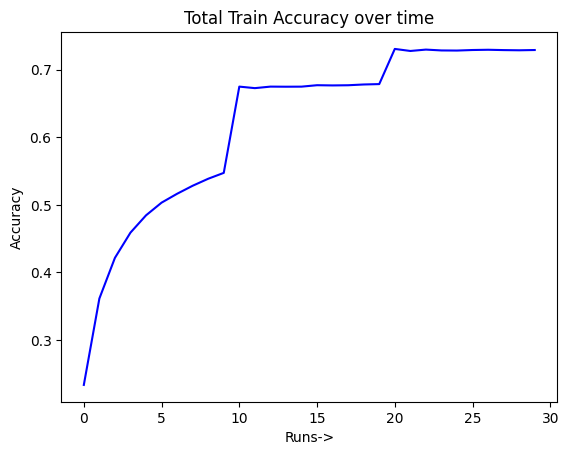

In [ ]:
# plot Accuracy
plt.plot(total_accuracy, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");

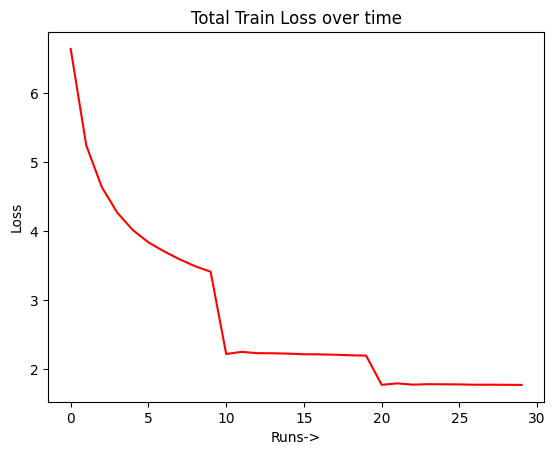

In [ ]:

# plot Loss
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

###Changing the Learning Rate

In [ ]:
#Incresing the learning rate

model = QAModel()

model = model.to('cuda')


if next(model.parameters()).is_cuda:
    print("Model is on CUDA (GPU).")
else:
    print("Model is on CPU.")

Model is on CUDA (GPU).


In [ ]:
learning_rate = 2e-4
weight_decay = 2e-2
gamma = 0.9
optimizer1 = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn1 = nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer1, gamma=gamma)
total_accuracy = []
total_loss = []

In [ ]:
#training
EPOCHS = 1

for epoch in range(EPOCHS):
    print("epoch number is " + str(epoch))
    train_acc, train_loss = train(model, train_data_loader, epoch+1, optimizer1, loss_fn1, 'checkpoint_loss_inc.pth')
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")


epoch number is 0


Current epoch number :   9%|▉         | 249/2714 [05:44<57:42,  1.40s/it]

current accuracy : 0.442375
current loss : 4.44983385848999


Current epoch number :   9%|▉         | 250/2714 [05:47<1:16:04,  1.85s/it]

Saving the model for epoch number 1


Current epoch number :  18%|█▊        | 499/2714 [11:38<52:02,  1.41s/it]

current accuracy : 0.490875
current loss : 3.9724703669548034


Current epoch number :  18%|█▊        | 500/2714 [11:41<1:10:22,  1.91s/it]

Saving the model for epoch number 1


Current epoch number :  28%|██▊       | 749/2714 [17:31<45:54,  1.40s/it]

current accuracy : 0.5111875
current loss : 3.7699453376134238


Current epoch number :  28%|██▊       | 750/2714 [17:35<1:04:40,  1.98s/it]

Saving the model for epoch number 1


Current epoch number :  37%|███▋      | 999/2714 [23:26<40:16,  1.41s/it]

current accuracy : 0.52415625
current loss : 3.6433178595304487


Current epoch number :  37%|███▋      | 1000/2714 [23:29<53:44,  1.88s/it]

Saving the model for epoch number 1


Current epoch number :  46%|████▌     | 1249/2714 [29:19<34:19,  1.41s/it]

current accuracy : 0.5339125
current loss : 3.54919780960083


Current epoch number :  46%|████▌     | 1250/2714 [29:22<45:49,  1.88s/it]

Saving the model for epoch number 1


Current epoch number :  55%|█████▌    | 1499/2714 [35:12<28:25,  1.40s/it]

current accuracy : 0.5393541666666667
current loss : 3.490472027460734


Current epoch number :  55%|█████▌    | 1500/2714 [35:15<37:48,  1.87s/it]

Saving the model for epoch number 1


Current epoch number :  64%|██████▍   | 1749/2714 [41:05<22:39,  1.41s/it]

current accuracy : 0.5444642857142857
current loss : 3.442061501775469


Current epoch number :  64%|██████▍   | 1750/2714 [41:08<30:09,  1.88s/it]

Saving the model for epoch number 1


Current epoch number :  74%|███████▎  | 1999/2714 [46:58<16:41,  1.40s/it]

current accuracy : 0.5497890625
current loss : 3.392787834882736


Current epoch number :  74%|███████▎  | 2000/2714 [47:01<22:23,  1.88s/it]

Saving the model for epoch number 1


Current epoch number :  83%|████████▎ | 2249/2714 [52:52<10:55,  1.41s/it]

current accuracy : 0.5529444444444445
current loss : 3.355032346036699


Current epoch number :  83%|████████▎ | 2250/2714 [52:55<14:41,  1.90s/it]

Saving the model for epoch number 1


Current epoch number :  92%|█████████▏| 2499/2714 [58:45<05:02,  1.41s/it]

current accuracy : 0.55543125
current loss : 3.325522145175934


Current epoch number :  92%|█████████▏| 2500/2714 [58:51<10:11,  2.86s/it]

Saving the model for epoch number 1


Current epoch number : 100%|██████████| 2714/2714 [1:03:52<00:00,  1.41s/it]

Train Accuracy: 0.5581418109855937      Train Loss: 3.304104300790968


In [ ]:
#testing
#testing the model

acc_list, test_acc = eval_model(model, test_data_loader)
print(f"Testing Accuracy: {test_acc} " )

Running Evaluation: 100%|██████████| 186/186 [01:30<00:00,  2.07it/s]

Testing Accuracy: 0.5882056451612904 


####Decreasing

















































 learning rate

In [ ]:
#Decreasing the Learning rate
model = QAModel()

model = model.to('cuda')


if next(model.parameters()).is_cuda:
    print("Model is on CUDA (GPU).")
else:
    print("Model is on CPU.")

Model is on CUDA (GPU).


In [ ]:
learning_rate = 2e-6
weight_decay = 2e-2
gamma = 0.9
optimizer1 = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn1 = nn.CrossEntropyLoss()
scheduler = ExponentialLR(optimizer1, gamma=gamma)
total_accuracy = []
total_loss = []

In [ ]:
EPOCHS = 1

for epoch in range(EPOCHS):
    print("epoch number is " + str(epoch))
    train_acc, train_loss = train(model, train_data_loader, epoch+1, optimizer1, loss_fn1, 'checkpoint_loss_dec.pth')
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")


epoch number is 0


Current epoch number :   9%|▉         | 249/2714 [05:43<57:33,  1.40s/it]

current accuracy : 0.0515
current loss : 9.892909648895264


Current epoch number :   9%|▉         | 250/2714 [05:46<1:17:20,  1.88s/it]

Saving the model for epoch number 1


Current epoch number :  18%|█▊        | 499/2714 [11:36<51:51,  1.40s/it]

current accuracy : 0.11334375
current loss : 8.64912321472168


Current epoch number :  18%|█▊        | 500/2714 [11:39<1:10:10,  1.90s/it]

Saving the model for epoch number 1


Current epoch number :  28%|██▊       | 749/2714 [17:29<46:18,  1.41s/it]

current accuracy : 0.1764375
current loss : 7.647636007944743


Current epoch number :  28%|██▊       | 750/2714 [17:32<1:02:30,  1.91s/it]

Saving the model for epoch number 1


Current epoch number :  37%|███▋      | 999/2714 [23:23<40:11,  1.41s/it]

current accuracy : 0.229453125
current loss : 6.943855566501617


Current epoch number :  37%|███▋      | 1000/2714 [23:26<53:46,  1.88s/it]

Saving the model for epoch number 1


Current epoch number :  46%|████▌     | 1249/2714 [29:16<34:22,  1.41s/it]

current accuracy : 0.27165
current loss : 6.434810050392151


Current epoch number :  46%|████▌     | 1250/2714 [29:19<46:27,  1.90s/it]

Saving the model for epoch number 1


Current epoch number :  55%|█████▌    | 1499/2714 [35:09<28:31,  1.41s/it]

current accuracy : 0.305625
current loss : 6.040744129975637


Current epoch number :  55%|█████▌    | 1500/2714 [35:21<1:34:31,  4.67s/it]

Saving the model for epoch number 1


Current epoch number :  64%|██████▍   | 1749/2714 [41:12<22:41,  1.41s/it]

current accuracy : 0.33435714285714285
current loss : 5.7212984051023215


Current epoch number :  64%|██████▍   | 1750/2714 [41:16<35:48,  2.23s/it]

Saving the model for epoch number 1


Current epoch number :  74%|███████▎  | 1999/2714 [47:06<16:51,  1.41s/it]

current accuracy : 0.3560625
current loss : 5.476795455217362


Current epoch number :  74%|███████▎  | 2000/2714 [47:09<22:39,  1.90s/it]

Saving the model for epoch number 1


Current epoch number :  83%|████████▎ | 2249/2714 [53:00<10:54,  1.41s/it]

current accuracy : 0.3748888888888889
current loss : 5.271304281340705


Current epoch number :  83%|████████▎ | 2250/2714 [53:03<15:11,  1.96s/it]

Saving the model for epoch number 1


Current epoch number :  92%|█████████▏| 2499/2714 [58:53<05:02,  1.41s/it]

current accuracy : 0.391125
current loss : 5.097340122032166


Current epoch number :  92%|█████████▏| 2500/2714 [58:56<06:46,  1.90s/it]

Saving the model for epoch number 1


Current epoch number : 100%|██████████| 2714/2714 [1:03:56<00:00,  1.41s/it]

Train Accuracy: 0.4025262527650959      Train Loss: 4.968911172452883


In [ ]:
#testing
#testing the model

acc_list, test_acc = eval_model(model, test_data_loader)
print(f"Testing Accuracy: {test_acc} " )

Running Evaluation: 100%|██████████| 186/186 [01:29<00:00,  2.07it/s]

Testing Accuracy: 0.5547715053763441 


###Evaluation Metrics